# Imports

In [1]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import sys
sys.path.insert(0,'../../')

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [3]:
filename = 'jokes_dataset.csv'
raw_df = pd.read_csv('../data/'+filename, sep=',',
                encoding='utf-8').set_index('id')

# work with copy
df = raw_df.copy(deep=True)

# Preprocessing

In [4]:
from src import schema as S
from src.preprocessing.preprocessing import SimplePreprocessor
from bs4 import BeautifulSoup

preprocessor = SimplePreprocessor()

# Dataset augmenting

In [5]:
import nlpaug.augmenter.word as naw

aug_syn = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=1)

In [6]:
from src.augmenting.augmenting import Augmenter

augmenter = Augmenter(aug_syn)

# Dataset tokenizer

In [7]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

INFO:filelock:Lock 1723627786000 acquired on C:\Users\Полина/.cache\huggingface\transformers\684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

INFO:filelock:Lock 1723627786000 released on C:\Users\Полина/.cache\huggingface\transformers\684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock
INFO:filelock:Lock 1723904265136 acquired on C:\Users\Полина/.cache\huggingface\transformers\c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

INFO:filelock:Lock 1723904265136 released on C:\Users\Полина/.cache\huggingface\transformers\c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 1723921097680 acquired on C:\Users\Полина/.cache\huggingface\transformers\fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

INFO:filelock:Lock 1723921097680 released on C:\Users\Полина/.cache\huggingface\transformers\fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Pipline

In [8]:
from src.pipeline.pipeline_generation import PipelineJokeGeneration

pipeline = PipelineJokeGeneration(
                 preprocessor = preprocessor,
                 tokenizer = tokenizer,
                 model_name = 'GPT2', 
                 splitting_params = {'test_size': 0.1,
                                     'shuffle': True},
                 )


In [9]:
 %%time
train_dataloader, validation_dataloader = pipeline.prepare_data(df)

DEBUG:pipeline-log:Starting preprocessing
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:pipeline-log:Starting tokenization
DEBUG:pipeline-log:Splitting dataset on train and val datasets
Wall time: 6min 49s


# Train

In [10]:
learning_rate = 5e-5

from transformers import AdamW
optimizer = AdamW

**1 epoch**

In [11]:
training_stats = pipeline.train_model(learning_rate,
                                    optimizer,
                                    train_dataloader,
                                    validation_dataloader,
                                    epochs=1)

INFO:pipeline-log:Fitting model
INFO:filelock:Lock 1722464008272 acquired on C:\Users\Полина/.cache\huggingface\transformers\752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e.323c769945a351daa25546176f8208b3004b6f563438a7603e7932bae9025925.lock


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

INFO:filelock:Lock 1722464008272 released on C:\Users\Полина/.cache\huggingface\transformers\752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e.323c769945a351daa25546176f8208b3004b6f563438a7603e7932bae9025925.lock
Beginning epoch 1 of 1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1458. Loss:0.842708170413971. Time:1:39:47
Example output:  bipartisan,. I, he says, is that it has a little bit, one little bit.
 they are.
 I have no, a little bit, of nothing.

'S:, the of an.
, is of the.
, the of.
, is of the.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1458. Loss:0.6073341369628906. Time:2:22:37
Example output:  increasingCatch up on a couple of funny bits of old reddit posts, you should check them out. They are pretty much every bit as bad asthe ones posted to reddit.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1458. Loss:0.5392032265663147. Time:3:06:27
Example output: dayI do not know how to say no to my father. It is an open secret."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1458. Loss:0.537186861038208. Time:3:56:55
Example output:  Hanga is a pretty old woman with long hair. She wears jeans, which are very heavy, and a look on her face. She is talking and she pulls out the other pants. She pulls them off. "What is this?" "What?!" "I told you, I am a woman like you and I just want to fuck my girlfriend, a girl like you. I am not going to come out this way if she gets me. If that happens I will find out what I do" She said slowly. "That is not how you do business" I said "That is not how you do business. You lie to me" She asked "What was that?" She said "My name is, Kaitlyn."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1458. Loss:0.6269429922103882. Time:4:54:32
Example output:  foodsIn that way she does not matter. She lives in my closet, and she will not change it for me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1458. Loss:0.6270925998687744. Time:6:02:09
Example output:  trailOne day in November, one of the oldest men in the neighborhood noticed a bus driving wrong on the east side of a bus station, and he was standing right back. He said "Why are there these bikes?" and turned to the bus driver. The bus driver said "They are running into a bear," which gave the bear a funny look. After sitting down in front of him, the bear said "Why are there so many snowplows? Because the snowplows are running off."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1458. Loss:0.5355405807495117. Time:7:18:48
Example output: intendSo what is the difference between an adult and a teenage boy? The guy just started having sex with the girl he loves in the shower.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1458. Loss:0.6750735640525818. Time:2 days, 11:36:23
Example output:  surroundI said, "I did not want the word 'hormone' in my mouth. My mum did not say anything to get my word out, so I just told her my name, she told my sister in the pub and I was told I got nothing to do with it. But my mum told me my sister will never let me down, and I gave her my money back in the bank."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1458. Loss:0.8896968960762024. Time:2 days, 13:12:20
Example output:  reflexG, B is B with a belt buckle. The belt buckle is the only part of your belt that fits properly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1458. Loss:0.6886553764343262. Time:2 days, 14:31:47
Example output:  displayWhy did a man with bad acne complain to the police


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1458. Loss:0.5230867862701416. Time:2 days, 16:10:53
Example output:  pastor" "What is the difference between a Christian and a hippy?" "I have nothing left to prove I am a hippy!" "I did not know that you do" "I know it is not quite as funny as you say it" "I guess it is funny when someone says something wrong" "Why?" "Because you think I am a hippy."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1458. Loss:0.5577566623687744. Time:2 days, 17:51:37
Example output:  illicitWhy did the French Mafia pay $ French Mafia for their prostitutes?" asked the bartender with a big smile.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1458. Loss:0.5051809549331665. Time:2 days, 19:30:29
Example output:  LiberationA man walks into a bar with a bottle of wine. He says "Sorry" and looks around. There is a woman behind him holding a glass. She asks, "Do you have a favorite bottle?" The man asks, "Why?" The woman replies, "Because it's beautiful and it comes up empty."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1458. Loss:0.5850701332092285. Time:2 days, 21:11:50
Example output:  NamAs a young man I got invited to my grandmother's wedding night. I thought that a lady was coming down the stairs, but when she came home she told me that I could not take my picture. So I said I would not post my picture unless there was something wrong with her nose. It was an accident!
Average Training Loss: 0.9114457630080941. Epoch time: 2 days, 22:09:06
Validation loss: 0.5918296329033228. Validation Time: 0:24:06
Total training took 2 days, 22:33:12


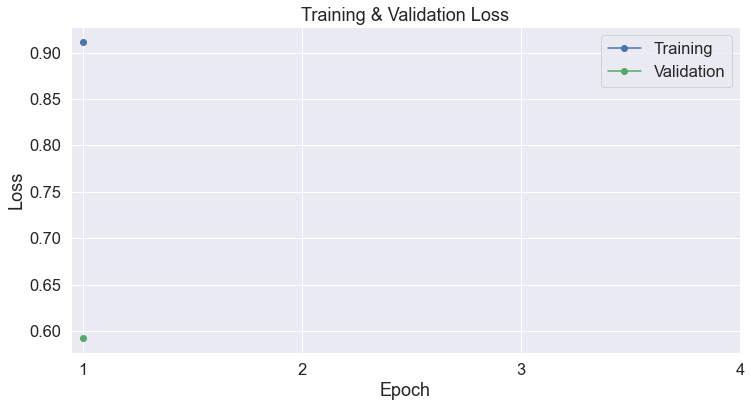

In [12]:
pipeline.draw_curves(training_stats)

# Generation

In [13]:
pipeline.generate()

INFO:pipeline-log:Starting jokes generation


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: A guy asks a girl what she likes about him. She replies "I have no idea."


1: A man walked into my office and saw the clock ticking... I thought he might not notice... Suddenly... My desk started vibrating... Suddenly, I felt some light coming through the lightbulb. The man said, "I have no idea how you ticked that clock." I thought, "I just went in and made sure you were all right." The man explained that he had a vibrator and said, "I do not know why you can see the clock when you are asleep. I have a phobia of clock-bulb noises, and I to know why you can see time and date on the clock without it having been vibrated." I said, "No, I do not see why it is vibrating."


2: I thought we were on the same planet but we now have a couple of planet.


3: An elderly patient asks if his doctor is a paedophile but his doctor replies, 'I do not want my patient to take a psychotherapist'.


4: The first time the police officer asked me to change my underwear, I said "I am sorry I am wearing 